# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import glob as glob
from multiprocessing import Pool
from scipy.optimize import curve_fit
import os
import sqlite3
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [119]:
def calculate_specific_heat(energies, kB, T, N, dimensions):
    avg_energy = np.mean(energies)
    energy_sq = np.mean(np.array(energies)**2)
    C = (energy_sq - avg_energy**2) / (kB * T**2 * N**dimensions)  # Specific heat
    return C

def initialize_lattice(N, N_alloys):
    n = int(np.ceil(0.5+np.sqrt(9+12*(N-1))/6)-1) #N1 = 1+ 6*n*(n-1)/2
    # -1 to offset the n meaning here
    print(n)
    radius = n
    points = generate_hexagonal_grid(radius,N_alloys)
    
    return points

def obj_fun(a1,a2):
    #print(a1,a2)
    return np.random.uniform(-1,1)

def calculate_energy(lattice):
    """Calculate the total energy of the lattice."""
    energy = 0
    for point in lattice:
        for neighbor in point.neighbors:
            energy+= obj_fun(point.alloy,neighbor.alloy)

    return energy/2

def calculate_delta_energy(point1, point2):
    """Calculate the energy difference for a proposed spin swap"""
    energy_before = 0
    energy_after = 0

    for neighbor in point1.neighbors:
        energy_before += obj_fun(point1.alloy,neighbor.alloy)
    for neighbor in point2.neighbors:
        energy_before += obj_fun(point2.alloy,neighbor.alloy)

    for neighbor in point1.neighbors:
        energy_after += obj_fun(point2.alloy,neighbor.alloy)
    for neighbor in point2.neighbors:
        energy_after += obj_fun(point1.alloy,neighbor.alloy)

    return energy_after - energy_before

def metropolis_step(lattice, kB, T, current_energy=None):
    [point1,point2] = random.sample(lattice, 2)

    deltaE = calculate_delta_energy(point1,point2)

    # Update proposal
    if deltaE < 0 or np.random.rand() < np.exp(-deltaE / (kB * T)):
        '''
        temp = point1.alloy
        point1.alloy = point2.alloy
        point2.alloy = temp
        '''
        point1.alloy, point2.alloy = point2.alloy, point1.alloy
        if current_energy is not None:
            current_energy += deltaE

    return deltaE, current_energy

######################################################################################
def save_simulation_data_sqlite(db_file, steps, lattices, energies, overwrite=False):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_file)
    c = conn.cursor()

    # Create tables if they don't exist
    c.execute('''CREATE TABLE IF NOT EXISTS simulation_steps
                 (step INTEGER PRIMARY KEY, energy REAL)''')
    c.execute('''CREATE TABLE IF NOT EXISTS lattices
                 (step INTEGER, lattice BLOB,
                  FOREIGN KEY(step) REFERENCES simulation_steps(step))''')

    if overwrite:
        # Clear existing data
        c.execute('DELETE FROM simulation_steps')
        c.execute('DELETE FROM lattices')

    # Insert or update rows in the database
    for step, energy, lattice in zip(steps, energies, lattices):
        # Serialize the lattice with Pickle
        pickled_lattice = pickle.dumps(lattice)

        # Insert or replace step data
        c.execute('''INSERT OR REPLACE INTO simulation_steps (step, energy)
                     VALUES (?, ?)''', (step, energy))

        # Insert or replace lattice data
        c.execute('''INSERT OR REPLACE INTO lattices (step, lattice)
                     VALUES (?, ?)''', (step, pickled_lattice))

    # Commit changes and close the connection
    conn.commit()
    conn.close()

def load_simulation_data_sqlite(db_file='simulation_state.sqlite', steps_to_load=None):
    conn = sqlite3.connect(db_file)
    c = conn.cursor()

    # Prepare the query
    query = '''SELECT s.step, s.energy, l.lattice
               FROM simulation_steps s
               LEFT JOIN lattices l ON s.step = l.step'''

    if steps_to_load:
        query += f" WHERE s.step IN ({','.join('?' for _ in steps_to_load)})"
        c.execute(query, steps_to_load)
    else:
        c.execute(query)

    loaded_steps, energies, lattices = [], [], []

    for step, energy, pickled_lattice in c.fetchall():
        # Unpickle the lattice
        lattice = pickle.loads(pickled_lattice) if pickled_lattice else None

        loaded_steps.append(step)
        energies.append(energy)
        lattices.append(lattice)

    conn.close()

    return np.array(loaded_steps), np.array(lattices), np.array(energies)


def load_last_simulation_state(simulation_state_file):
    """Loads the last simulation state from the SQLite database."""
    if not os.path.exists(simulation_state_file):
        return None, None, None, 0  # Indicates that there is no previous state

    with sqlite3.connect(simulation_state_file) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT MAX(step) FROM simulation_steps")
        last_step = cursor.fetchone()[0]
        if last_step is None:
            return None, None, None, 0

        cursor.execute("SELECT energy FROM simulation_steps WHERE step = ?", (last_step,))
        step_data = cursor.fetchone()
        energy = step_data[0] if step_data else (None)

        cursor.execute("SELECT lattice FROM lattices WHERE step = ?", (last_step,))
        lattice_data = cursor.fetchone()
        lattice = pickle.loads(lattice_data[0]) if lattice_data and lattice_data[0] else None

        return last_step, lattice, energy, last_step
    

def run_simulation(N, T, kB, N_alloys, steps=10000, save_interval=100, chunk_size=100, simulation_state_file='simulation_state.sqlite'):
    T +=(10**-6)
    
    # Load last simulation state if exists
    last_step, last_lattice, last_energy, completed_steps = load_last_simulation_state(simulation_state_file)
    
    if completed_steps >= steps:
        print(f"Simulation already completed up to {completed_steps} steps.")
        return True
    
    # Initialize simulation from the last saved state or start a new simulation
    if last_step is not None and last_lattice is not None:
        lattice = last_lattice
        current_energy = last_energy
        start_step = last_step + 1
        print(f"Resuming from step {last_step}.")
    else:
        lattice = initialize_lattice(N, N_alloys)
        current_energy = calculate_energy(lattice)
        start_step = 1
    
    accumulated_steps = []
    accumulated_lattices = []
    accumulated_energies = []

    for step in range(start_step, steps + 1):
        deltaE, current_energy = metropolis_step(lattice, kB, T, current_energy)
        
        if step % save_interval == 0 or step == steps:
            accumulated_steps.append(step)
            accumulated_lattices.append(lattice.copy())
            accumulated_energies.append(current_energy)
            
            if len(accumulated_steps) == chunk_size or step == steps:
                save_simulation_data_sqlite(simulation_state_file, accumulated_steps, accumulated_lattices, accumulated_energies, overwrite=False)
                print(f"Saved step {step}.")
                
                # Clear accumulated data after saving
                accumulated_steps = []
                accumulated_lattices = []
                accumulated_energies = []

    return True
########################################################################################
hex_directions = [
    (1, 0), (1, -1), (0, -1),
    (-1, 0), (-1, 1), (0, 1)
]
class LatticePoint:
    def __init__(self, x, y, q, r, alloy):
        self.x = x
        self.y = y
        self.q = q  # Adding axial coordinates
        self.r = r
        self.alloy = alloy
        self.neighbors = []  # Initialize an empty list for neighbors

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

def hex_to_pixel(q, r, size=1):
    """
    Convert hexagonal grid coordinates (q, r) to Cartesian (x, y).
    Size controls the spacing between the hexagons.
    """
    x = size * (3./2 * q)
    y = size * (np.sqrt(3)/2 * q + np.sqrt(3) * r)
    return (x, y)

def generate_hexagonal_grid(radius,N_alloys):
    points = {}  # Use a dictionary to store points by their (q, r) for easy lookup
    # Generate points
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            x, y = hex_to_pixel(q, r)
            alloy = np.random.randint(1, N_alloys+1)  # Random alloy between 1 and 3
            points[(q, r)] = LatticePoint(x, y, q, r, alloy)
    
    # Assign neighbors
    for q, r in points:
        point = points[(q, r)]
        for dq, dr in hex_directions:
            neighbor_coords = (q + dq, r + dr)
            if neighbor_coords in points:
                point.add_neighbor(points[neighbor_coords])
    
    return list(points.values())

def plot_hexagonal_grid_with_neighbors(points, q=None, r=None):
    hexagon_radius=1
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.set_aspect('equal')

    if q==None or r==None:
        # Randomly select a point as the focal point
        focal_point = random.choice(points)
    else:
        # Find the focal point based on q and r
        focal_point = next((point for point in points if point.q == q and point.r == r), None)
    
    if not focal_point:
        print(f"No hexagon found at axial coordinates ({q}, {r}).")
        return
    
    # Highlight the focal point
    focal_hexagon = patches.RegularPolygon(
        (focal_point.x, focal_point.y), numVertices=6, radius=hexagon_radius,
        orientation=np.pi/6, edgecolor='black', facecolor='yellow'
    )
    ax.add_patch(focal_hexagon)
    ax.text(focal_point.x, focal_point.y, str(focal_point.alloy), color='black', fontsize=14, ha='center', va='center')
    
    # Highlight neighbors of the focal point
    for neighbor in focal_point.neighbors:
        neighbor_hexagon = patches.RegularPolygon(
            (neighbor.x, neighbor.y), numVertices=6, radius=hexagon_radius,
            orientation=np.pi/6, edgecolor='black', facecolor='lightblue'
        )
        ax.add_patch(neighbor_hexagon)
        ax.text(neighbor.x, neighbor.y, str(neighbor.alloy), color='red', fontsize=14, ha='center', va='center')

    # Add the rest of the points
    for point in points:
        if point not in focal_point.neighbors and point != focal_point:
            hexagon = patches.RegularPolygon(
                (point.x, point.y), numVertices=6, radius=hexagon_radius,
                orientation=np.pi/6, edgecolor='black', facecolor='none'
            )
            ax.add_patch(hexagon)
            #ax.plot(point.x, point.y, 'o', color='blue')
            ax.text(point.x, point.y, str(point.alloy), color='blue', fontsize=14, ha='center', va='center')

    # Setting the plot limits dynamically based on the hexagon size and grid radius
    plot_radius = hexagon_radius * 2 * (radius+0.1)
    ax.set_xlim(-plot_radius, plot_radius)
    ax.set_ylim(-plot_radius, plot_radius)
    ax.axis('off')  # Hide axis for better visualization
    plt.show()



# Workflow

[<__main__.LatticePoint object at 0x179889840>, <__main__.LatticePoint object at 0x179889390>, <__main__.LatticePoint object at 0x179889060>, <__main__.LatticePoint object at 0x179888eb0>, <__main__.LatticePoint object at 0x179889c60>, <__main__.LatticePoint object at 0x1798895a0>, <__main__.LatticePoint object at 0x179889510>, <__main__.LatticePoint object at 0x179889540>, <__main__.LatticePoint object at 0x179889780>, <__main__.LatticePoint object at 0x1798895d0>, <__main__.LatticePoint object at 0x179889900>, <__main__.LatticePoint object at 0x179889b10>, <__main__.LatticePoint object at 0x179889ae0>, <__main__.LatticePoint object at 0x179889a80>, <__main__.LatticePoint object at 0x179889930>, <__main__.LatticePoint object at 0x179889750>, <__main__.LatticePoint object at 0x1798899c0>, <__main__.LatticePoint object at 0x179889b40>, <__main__.LatticePoint object at 0x179889c00>, <__main__.LatticePoint object at 0x179889d50>, <__main__.LatticePoint object at 0x179889990>, <__main__.La

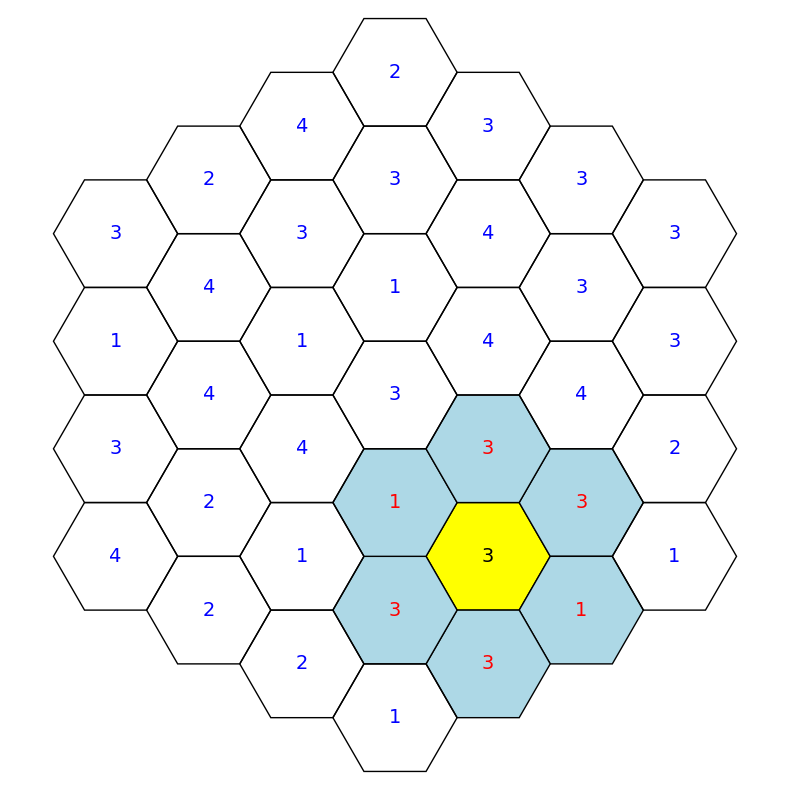

In [120]:
# Test visualization
radius = 3
N_alloys = 4

# Assuming the rest of the setup remains unchanged
points_with_neighbors = generate_hexagonal_grid(radius,N_alloys)
print(points_with_neighbors)

q_choice, r_choice = None,None#0,0
# New visualization showcasing a randomly chosen point and its neighbors
plot_hexagonal_grid_with_neighbors(points_with_neighbors, q=q_choice, r=r_choice)


2
19


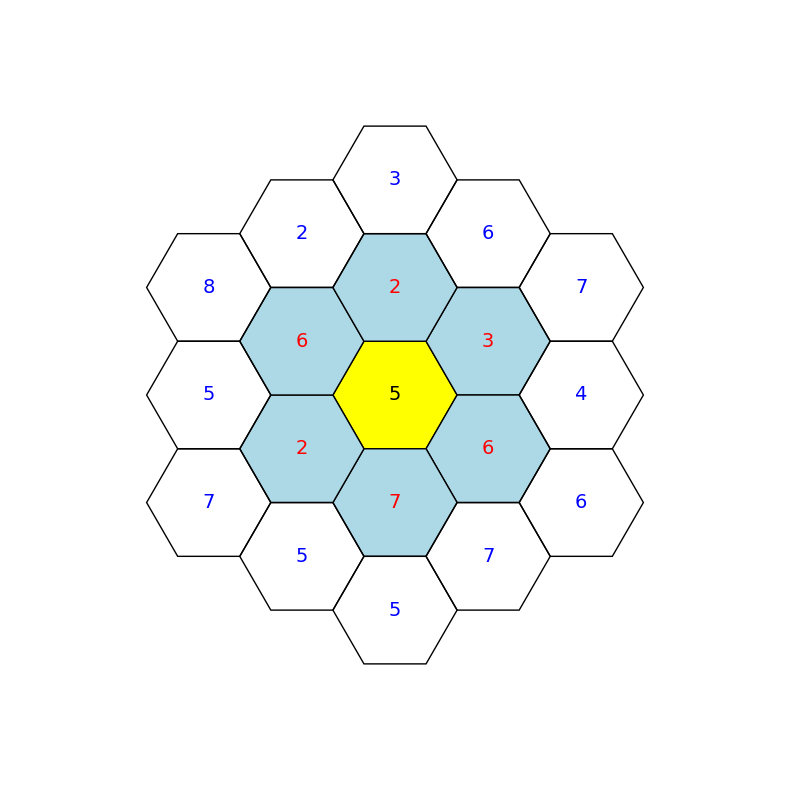

-19.6182550612626


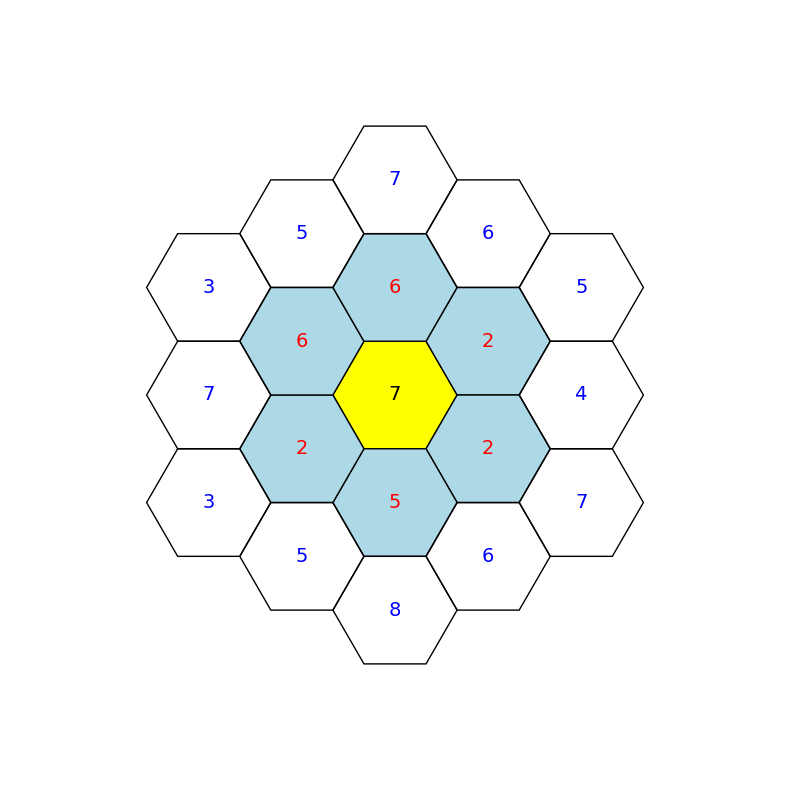

-37.50296983478124


In [121]:
# Test functions
N=8;N_alloys = N
lattice = initialize_lattice(N, N_alloys)
print(len(lattice))
plot_hexagonal_grid_with_neighbors(lattice, 0,0)
current_energy = calculate_energy(lattice)
print(current_energy)
for i in range(100):
    deltaE,current_energy = metropolis_step(lattice, kB=1, T=1, current_energy=current_energy)
plot_hexagonal_grid_with_neighbors(lattice, 0,0)
print(current_energy)

In [122]:
# Test simulation
run_simulation(N, T=10, kB=1, N_alloys=N_alloys,steps=100000)
loaded_steps, lattices, energies = load_simulation_data_sqlite()

Simulation already completed up to 100000 steps.


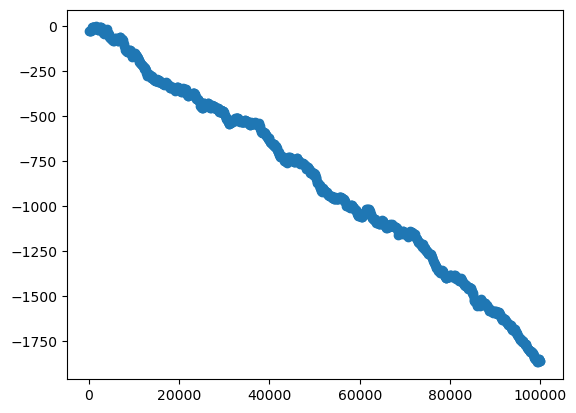

In [123]:
plt.scatter(loaded_steps,energies)

1000


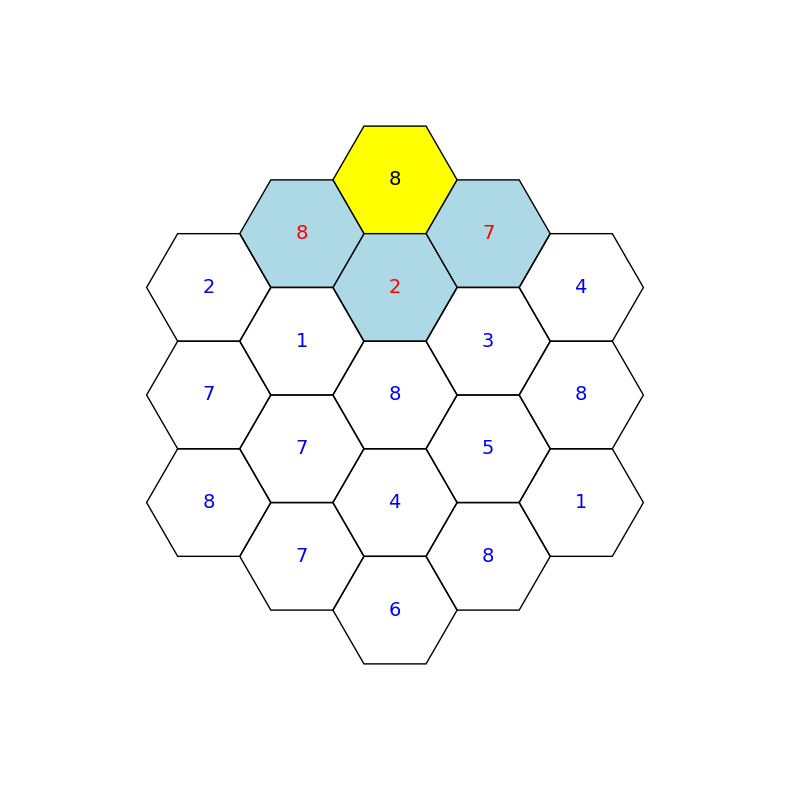

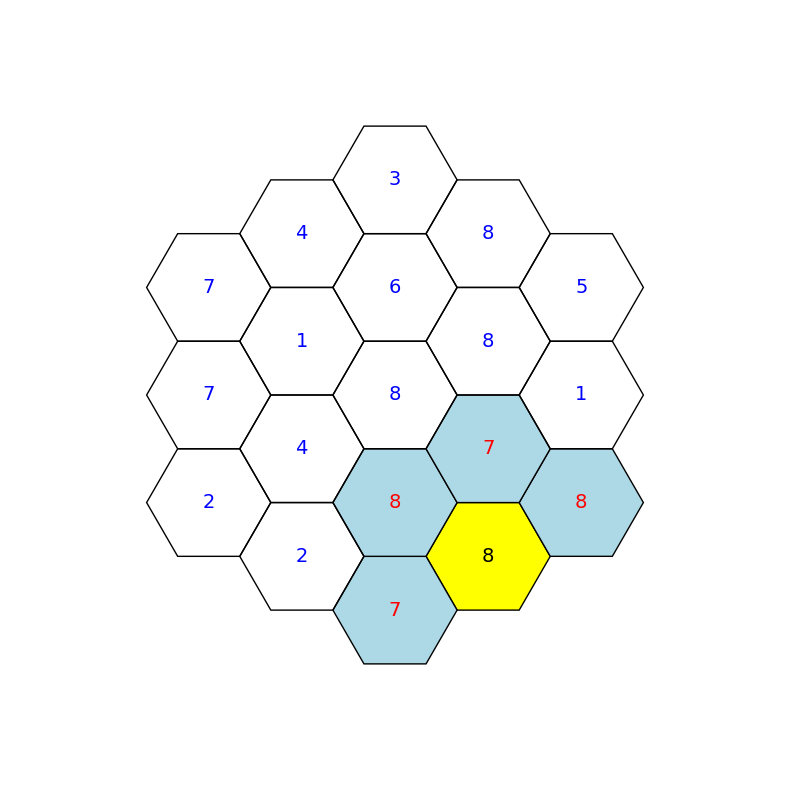

In [124]:
print(len(lattices))
plot_hexagonal_grid_with_neighbors(lattices[0])
plot_hexagonal_grid_with_neighbors(lattices[-1])